### <center>Objective :- Build a model in identifying high performing employees for a given job and client </center>

### Features Description:- Predominantly HR and Payroll attributes of employee are considered 
<font color = 'blue'>Note : We will continue to explore other features as well to be part of the model</font>
    1. Bonus_Ratio: Proportion of annual bonus amount wrt the total annual compensation
    2. Salary Hike: salary hike percentage for a employee in a year
    3. Compa Ratio: peers compensation ratio of an employee in the company
    4. promotion rate: number of promotion/tenure of the employee
    5. span change: Rate of change of span(direct+indirect reportees).

# Summary:
 
    - Client name: The Wonderfull company(G3AMKMQ4X429D89D)
    - Industry: Manufacturing
    - Emplopyee count: 10589
    - Total unique jobs count: 606
    - Total unique jobs counts(employee count>10):142
 

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from adp.impala.client import *
from adp.impala.sample import *
from impala.dbapi import connect
import math
from math import pi
import collections
from collections import Counter
import operator
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.stats import normaltest
import matplotlib.gridspec as gridspec
import scipy.stats as stat
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'adp'

In [257]:
! echo "jimkimnim07&" | kinit tiwarij@HADOOP.CDL1.ADP.COM

Password for tiwarij@HADOOP.CDL1.ADP.COM: 


In [1]:
def cleandf(dataframe,removeLowTenure=False):
    '''this will delete record with tenure=0.0 or -0.0 also it will create columns promotion rate'''
    dataframe.drop(dataframe.index[(dataframe['tenure']==-0.0) | (dataframe['tenure'].isnull()) | (dataframe['tenure']==0.0)],inplace=True)## pu this also 
    ##dataframe.drop('precal_bonus_rt',axis=1,inplace=True)
    dataframe.fillna(0,inplace=True)
    dataframe.drop(['annual_comp','bonus_raw'],axis=1,inplace=True)
    if(removeLowTenure==True):
        dataframe.drop(dataframe.index[(dataframe['tenure']<1.0)],inplace=True)## put this also 
    dataframe['promotion_rate'] = dataframe['promotions']/dataframe['tenure']
    dataframe['promotion_rate_change']=dataframe['promotion_rate_change']/dataframe['tenure']

In [259]:
def set_span(data):
    '''we have some job where span_Change is in negative to balance that out we are adding the minimum span_change to all rows'''
    data['span_change'] = data['span_change']+[0 if np.min(data['span_change'])>0 else np.abs(np.min(data['span_change']))+0.0001] 
    return data

In [260]:
def getDataframe_30Emp(data,year,cutoff):
    df = pd.merge(data[data['year']==year],data[data['year']==year].groupby('job_dsc').aoid.agg({'count':'count'}).reset_index(),on=['job_dsc'])
    df = df[df['count']>=cutoff]
    df.drop('count',axis=1,inplace=True)
    return df
    del(df)

In [261]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [262]:
def draw_percentile_radar_plot(sample_size,dataframe_quantile,labels):
    dataframe_quantile['bonus_ratio_percentile'] =dataframe_quantile.groupby('job_dsc')["bonus_ratio"].apply(lambda ser: pd.Series([stats.percentileofscore(ser, x) for x in ser], index=ser.index))
    dataframe_quantile['salary_hike_percentile'] =dataframe_quantile.groupby('job_dsc')["salary_hike"].apply(lambda ser: pd.Series([stats.percentileofscore(ser, x) for x in ser], index=ser.index))
    dataframe_quantile['compa_rt_percentile'] =dataframe_quantile.groupby('job_dsc')["compa_rt"].apply(lambda ser: pd.Series([stats.percentileofscore(ser, x) for x in ser], index=ser.index))
    dataframe_quantile['tenure_percentile'] =dataframe_quantile.groupby('job_dsc')["tenure"].apply(lambda ser: pd.Series([stats.percentileofscore(ser, x) for x in ser], index=ser.index))
    dataframe_quantile['promotion_rate_percentile'] =dataframe_quantile.groupby('job_dsc')["promotion_rate"].apply(lambda ser: pd.Series([stats.percentileofscore(ser, x) for x in ser], index=ser.index))
    fig=plt.figure(figsize = (50,80))
    jobs=['Retail Sales Merchandiser','District Sales Manager','Sales Manager I']
    gs1 = gridspec.GridSpec(len(jobs)*2,sample_size)
    N=len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    for index,job_name in enumerate(jobs):
        print("job_name>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>:{0}".format(job_name))
        lower_range=index*(sample_size*2)
        high_rage=lower_range+(sample_size*2)
        grp=dataframe_quantile[dataframe_quantile.job_dsc==job_name]
        if grp[grp.Isbestperformer_normalized.notnull()].shape[0]>=sample_size:
            bestperfomer=grp[grp.Isbestperformer_normalized.notnull()].sample(n=sample_size).reset_index()
        else:
            bestperfomer=grp[grp.Isbestperformer_normalized.notnull()].sample(n=grp[grp.Isbestperformer_normalized.notnull()].shape[0]).reset_index()
        non_bestperfomer=grp[(grp.Isbestperformer_normalized.isnull())&
                   ((grp[labels[0]]>10)&(grp[labels[0]]<60))&
                  ((grp[labels[1]]>10)&(grp[labels[1]]<60))&
                  ((grp[labels[2]]>10)&(grp[labels[2]]<60))].sample(n=sample_size).reset_index()
        percentil_values=[]
        for col in labels:
            percentil_values.append(grp[col].quantile(0.90))
        percentil_values += percentil_values[:1]
        line_devider=lower_range+sample_size-1
        for i,value in enumerate(range(lower_range,high_rage)):
            ax = plt.subplot(gs1[value],polar=True)
            plt.xticks(angles[:-1], labels, color='grey', size=18,)
            ax.set_rlabel_position(0)
#             plt.yticks([0,25,50,75,1], [0,25,50,75,1], color="grey", size=27)
            plt.ylim(10,100)
            
            if (value<=line_devider):
                try:
                    values=bestperfomer[labels].loc[i].values.flatten().tolist()
                    values += values[:1]
                    ax.plot(angles, values, linewidth=2, linestyle='solid',color='green')
                    ax.fill(angles, values, alpha=0.1)
                    title=job_name+" Best Performer {0}".format(i)
                    ax.set_title(label=title,size=35)
                    print("values",values)
                    if "percentile" not in labels[0]:
                        ax.plot(angles, percentil_values, linewidth=2, linestyle='solid',color='red')
                        ax.fill(angles, percentil_values, 'r', alpha=0.1)
                except Exception as e:
                    print("{0} job doesn't have sample number of best performers."\
                    "This will create empty star plots in {0} best preformers row.".format(job_name))

            else:
                values=non_bestperfomer[labels].loc[i-sample_size].values.flatten().tolist()
                values += values[:1]
                ax.plot(angles, values, linewidth=2, linestyle='solid',color='green')
                ax.fill(angles, values, alpha=0.1)
                title=job_name+" Non Best Performer {0}".format(i-sample_size)
                ax.set_title(label=title,size=35)
                if "percentile" not in labels[0]:
                    ax.plot(angles, percentil_values, linewidth=2, linestyle='solid',color='red')
                    ax.fill(angles, percentil_values, 'red', alpha=0.1)
    plt.show()

In [3]:
def calculate_employee_score_with_normalised(job_group,feature_list =[],sigma=None):
    
    '''this will give us employee score based on std and mad'''
    print("******"*10)
    if(sigma==None):
        percentile = 0.90
    else:    
        percentile =  stats.norm.cdf(sigma)
        
    temp = job_group[['bonus_ratio_normalised','salary_hike_normalised','compa_rt_normalised','promotion_rate_normalised','span_change_normalised',
                     'bonus_rate_change_normalised','salary_hike_rate_change_normalised','compa_rt_rate_change_normalised','promotion_rate_change_normalised','commision_normalised']]
    bonus_median = np.median(temp.bonus_ratio_normalised)
    salary_median = np.median(temp.salary_hike_normalised)
    compart_median = np.median(temp.compa_rt_normalised)
    promo_median = np.median(temp.promotion_rate_normalised)
    span_change_median = np.median(temp.span_change_normalised)
    commision_median = np.median(temp.commision_normalised)
    bonus_rate_change_median = np.median(temp.bonus_rate_change_normalised)
    salary_hike_rate_change_median = np.median(temp.salary_hike_rate_change_normalised)
    compa_rt_rate_change_median = np.median(temp.compa_rt_rate_change_normalised)
    promotion_rate_change_median = np.median(temp.promotion_rate_change_normalised)

    stdfeature = {}
    madfeature= {}
    feature_weights = []
    if(bonus_median==0.0 or salary_median==0.0 or compart_median==0.0 or promo_median or span_change_median==0.0 or commision_median==0.0) :
        print('--using Standard Deviation important feature:-')
        stdfeature.update({'bonus_ratio':np.std(temp.bonus_ratio_normalised),
                           'salary_hike':np.std(temp.salary_hike_normalised),
                           'compa_rt':np.std(temp.compa_rt_normalised),
                          'promotion_rate':np.std(temp.promotion_rate_normalised),
                          'span_change':np.std(temp.span_change_normalised),
                           'commision':np.std(temp.commision_normalised),
                           'bonus_rate_change':np.std(temp.bonus_rate_change_normalised),
                           'salary_hike_rate_change':np.std(temp.salary_hike_rate_change_normalised),
                          'compa_rt_rate_change':np.std(temp.compa_rt_rate_change_normalised),
                          'promotion_rate_change':np.std(temp.promotion_rate_change_normalised)
                           })
    else:
        print('--using MAD important feature:-')
        stdfeature.update({'bonus_ratio':np.median(abs(temp.bonus_ratio_normalised-bonus_median)),
                           'salary_hike':np.median(abs(temp.salary_hike_normalised-salary_median)),
                          'compa_rt':np.median(abs(temp.compa_rt_normalised-compart_median)),
                          'promotion_rate':np.median(abs(temp.promotion_rate_normalised-promo_median)),
                          'span_change':np.median(abs(temp.span_change_normalised-span_change_median)),
                           'commision':np.median(abs(temp.commision_normalised-commision_median)),
                          'bonus_rate_change':np.median(abs(temp.bonus_rate_change_normalised-bonus_rate_change_median)),
                          'salary_hike_rate_change':np.median(abs(temp.salary_hike_rate_change_normalised-salary_hike_rate_change_median)),
                          'compa_rt_rate_change':np.median(abs(temp.compa_rt_rate_change_normalised-compa_rt_rate_change_median)),
                          'promotion_rate_change':np.median(abs(temp.promotion_rate_change_normalised-promotion_rate_change_median))
                          })
        
    job_group["bonus_ratio_weightage"]=stdfeature["bonus_ratio"]
    job_group["salary_hike_weightage"]=stdfeature["salary_hike"]
    job_group["compa_rt_weightage"]=stdfeature["compa_rt"]
    job_group["promotion_rate_weightage"]=stdfeature["promotion_rate"]
    job_group["span_change_weightage"]=stdfeature["span_change"]
    job_group["commision_weightage"]=stdfeature["commision"]
    job_group["bonus_rate_change_weightage"]=stdfeature["bonus_rate_change"]
    job_group["salary_hike_rate_change_weightage"]=stdfeature["salary_hike_rate_change"]
    job_group["compa_rt_rate_change_weightage"]=stdfeature["compa_rt_rate_change"]
    job_group["promotion_rate_change_weightage"]=stdfeature["promotion_rate_change"]

    if(feature_list==[]):
        stdfeature = stdfeature
    else:
        stdfeature = dict((k, stdfeature[k]) for k in (feature_list))
    sorted_std = sorted(stdfeature.items(), key=operator.itemgetter(1),reverse=False)
    expression="({0}['{1}']*{2})"
    condition=""
    sorted_std=[tup for tup in sorted_std if not math.isnan(tup[1])]
    print(job_group["job_dsc"].iloc[0])
    print("sorted_std",sorted_std)
    ##print(job_group["job_dsc"].iloc[0])
    denom=0
    for index,value in enumerate(sorted_std):
        condition+=expression.format("job_group",value[0]+"_normalised",value[1])
        denom+=value[1]
        if index<len(sorted_std)-1:
            condition+="+"
    if  not condition:
        job_group["employee_score"]=0
    else:
        job_group["employee_score"]=eval(condition)/denom    
    job_group["employee_score"] = job_group["employee_score"]+0.0001
    data_box = job_group["employee_score"]
    stat,p = shapiro(data_box)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if(p>=0.05):
        job_group['employee_score_normalized'] = job_group["employee_score"]
    else:
        df,lambda_val = boxcox(job_group.employee_score)
        job_group['employee_score_normalized'] = boxcox(job_group.employee_score,lambda_val)
    stat_norm,p_norm = shapiro(job_group['employee_score_normalized']) 
    print("After transforming p value:",p_norm)
    
    job_group["employee_score_normalized_90_percentile"]=job_group["employee_score_normalized"].quantile(percentile)
    job_group["employee_score_90_percentile"]=job_group["employee_score"].quantile(0.90)
    return job_group

In [264]:
def detect_bestperformer(df):
    df["Isbestperformer_normalized"]=np.where(df["employee_score_normalized"]>df["employee_score_normalized_90_percentile"],df.aoid,np.NaN)
    df["Isbestperformer_nonorm"]=np.where(df["employee_score"]>df["employee_score_90_percentile"],df.aoid,np.NaN)
    return df

In [265]:
def get_distribution_empscore(dataframe,job_list=[]):
    plt.figure(figsize=(20,25))
    size=0
    if(job_list==[]):
        size=len(dataframe.job_dsc.unique())
    else:
        size=len(job_list)
    gs1 = gridspec.GridSpec(size,3)
    for index ,job in enumerate(job_list):
        bins = None
        if(job.lower()=='sales manager ii' or job.lower()=='regional sales manager'):
            bins= 7
        elif(job.lower()=='sales director i' or job.lower()=='territory sales manager'):
            bins=4
        elif(job.lower()=='sales specialist' or job.lower()=='retail sales manager' or job.lower()=='retail sales merchandiser',job.lower()=='sales representative'):
            bins=6
        elif(job.lower()=='sales manager i'):
            bins = 5
        ##print(job,bins)
        plt.suptitle('Employee Score normalized Distribution',x=0.5,y=0.9,color='blue',fontsize=20)
        ax=plt.subplot(gs1[index])
        ax.set_title(job,color='red')
        sns.distplot(dataframe[dataframe['job_dsc']==job].employee_score_normalized,bins=bins,color='red',axlabel=False,hist_kws=dict(edgecolor="k", linewidth=2))
        ##ax.hist(data_2[data_2['job_dsc']==job].employee_score_normalized,bins=6)
        plt.subplots_adjust(hspace =0.4)

In [266]:
def get_distribution_empscore_nonormalized(dataframe,job_list=[]):
    plt.figure(figsize=(20,25))
    size=0
    if(job_list==[]):
        size=len(dataframe.job_dsc.unique())
    else:
        size=len(job_list)
    gs1 = gridspec.GridSpec(size,3)
    for index ,job in enumerate(job_list):
        bins = None
        if(job.lower()=='sales manager ii' or job.lower()=='regional sales manager'):
            bins= 7
        elif(job.lower()=='sales director i' or job.lower()=='territory sales manager'):
            bins=4
        elif(job.lower()=='sales specialist' or job.lower()=='retail sales manager' or job.lower()=='retail sales merchandiser',job.lower()=='sales representative'):
            bins=6
        elif(job.lower()=='sales manager i'):
            bins = 5
        ##print(job,bins)
        plt.suptitle('Employee Score w/o normalizingDistribution',x=0.5,y=0.9,color='blue',fontsize=20)
        ax=plt.subplot(gs1[index])
        ax.set_title(job,color='red')
        sns.distplot(dataframe[dataframe['job_dsc']==job].employee_score,bins=bins,color='blue',axlabel=False,hist_kws=dict(edgecolor="k", linewidth=2))
        ##ax.hist(data_2[data_2['job_dsc']==job].employee_score_normalized,bins=6)
        plt.subplots_adjust(hspace =0.4)

In [267]:
def get_qqplot(dataframe,job_list=[]):
    size=0
    if(job_list==[]):
        size=len(dataframe.job_dsc.unique())
    else:
        size=len(job_list)
    plt.figure(figsize=(20,25))
    gds1 = gridspec.GridSpec(size,3)
    for index,job in enumerate(job_list):
        ax = plt.subplot(gds1[index])
        stat.probplot(dataframe[dataframe['job_dsc']==job].employee_score_normalized,dist='norm',plot=plt)
        ax.set_title(job,color='red')
        plt.suptitle('QQ plot Employee Score normalized',x=0.5,y=0.9,color='blue',fontsize=20)
        plt.subplots_adjust(hspace =0.5)

In [268]:
# data=retrieve_from_hadoop("select * from fitdsmain.performance_inferences_dataset4 where ooid='G3AMKMQ4X429D89D'")
# data["year"]=data['year'].astype(int)
# # data = pd.read_csv("thewndfullwithspan.csv",header=0)
# print('shape when all employees are taken:-',data.shape)
# cleandf(data,removeLowTenure=True)## to remove any record with 0 as tenure 
# data = data.groupby('job_dsc').apply(set_span)
# print('after removing low tenure:-',data.shape)

('shape when all employees are taken:-', (11896, 14))
('after removing low tenure:-', (6406, 15))


In [4]:
data = pd.read_csv("thewonderfullcompany.csv",header=0)
print('shape when all employees are taken:-',data.shape)
cleandf(data,removeLowTenure=True)
data = data.groupby('job_dsc').apply(set_span)
print('after removing low tenure:-',data.shape)

NameError: name 'pd' is not defined

#### removing jobs with less than 10 employee

In [269]:
data = getDataframe_30Emp(data,year=2017,cutoff=10)

In [270]:
##top_10_jobs = data.groupby(['job_dsc'])['aoid'].agg({"emp_count": len}).sort_values("emp_count", ascending=False).head(20).reset_index()
lis_jobs = ['Associate I','Associate VI','Citrus Processor','Equipment Operator III','Warehouse Person','Director I','Supervisor II','Retail Sales Merchandiser','Sales Specialist','District Sales Manager','General Labor - Seasonal','Lead-Packinghouse']
sales_like_job = data[data['job_dsc'].str.contains('Sales')].job_dsc.unique()

#### creating new DF with only Sales jobs

In [271]:
data_2=data[data["job_dsc"].isin(sales_like_job)]
print(data_2.shape)

(351, 15)


#### scaling the feature between 0 to 1

In [272]:
col_names = ['bonus_ratio','salary_hike','compa_rt','promotion_rate','span_change',
             'bonus_rate_change','salary_hike_rate_change','compa_rt_rate_change','promotion_rate_change']
col_names_normalised=[col+"_normalised" for col in col_names]
normalize=lambda x: (x - x.min()) / (x.max() - x.min())
data_2[col_names_normalised] = data_2.groupby(["ooid","job_dsc"])[col_names].transform(normalize)

In [273]:
data_2=data_2.groupby(["job_dsc"]).apply(calculate_employee_score_with_normalised)

************************************************************
--using MAD important feature:-
District Sales Manager
('sorted_std', [('salary_hike', 0.0), ('promotion_rate_change', 0.0), ('promotion_rate', 0.0), ('span_change', 0.0), ('salary_hike_rate_change', 0.0), ('compa_rt_rate_change', 0.013610647394298403), ('bonus_rate_change', 0.015458219605955385), ('bonus_ratio', 0.046511224435360307), ('compa_rt', 0.10182713508678989)])
Statistics=0.937, p=0.023
('After transforming p value:', 0.5803406834602356)
************************************************************
--using MAD important feature:-
District Sales Manager
('sorted_std', [('salary_hike', 0.0), ('promotion_rate_change', 0.0), ('promotion_rate', 0.0), ('span_change', 0.0), ('salary_hike_rate_change', 0.0), ('compa_rt_rate_change', 0.013610647394298403), ('bonus_rate_change', 0.015458219605955385), ('bonus_ratio', 0.046511224435360307), ('compa_rt', 0.10182713508678989)])
Statistics=0.937, p=0.023
('After transforming p val

### this table show the number of highperformer only for Sales like Jobs

In [274]:
data_2=data_2.groupby("job_dsc").apply(detect_bestperformer)
## percentage of people as highperformer
df_highperformer = pd.merge(data_2.groupby('job_dsc').aoid.nunique().to_frame(name='total_employee').reset_index(),data_2[data_2['Isbestperformer_normalized'].notnull()].groupby('job_dsc').Isbestperformer_normalized.nunique().to_frame(name='HighPerformer').reset_index(),on='job_dsc')   
df_highperformer['HighPerformer%'] = (df_highperformer['HighPerformer']/df_highperformer['total_employee'])*100
df_highperformer

,job_dsc,total_employee,HighPerformer,HighPerformer%
0,District Sales Manager,42,5,11.904762
1,Regional Sales Manager,49,5,10.204082
2,Retail Sales Merchandiser,143,15,10.489510
3,Sales Director I,21,2,9.523810
4,Sales Manager I,32,4,12.500000
5,Sales Manager II,11,1,9.090909
6,Sales Representative,20,2,10.000000
7,Sales Specialist,12,2,16.666667
8,Territory Sales Manager,21,2,9.523810


### <center>Stepwise Approach</center>
- Idea is to formulate this problem of detecting High performers as an outlier detection problem .
    - **Approach** : For a normal distribution on target variable ( Employee score ) put a threshold based on n sigma from mean ,to detect prospective outliers
    - **Employee score** : Weighted average of the feature values for each employees , wherein weights for features are statistically identified for each job ( in future version , weights could be assigned by User as well)
    - Normality test for each feature in every job.
        - Shapiro wilk test of nomality : **NULL HYPOTHESIS** : Distribution is normal , **alpha = 0.05**
    - Features not following normal distribution , apply **box-cox transformation** to convert it into a normal distribution
    - Identify outliers based on sigma threshold .
    

### <center>EDA and Outlier detection for Sales specific jobs</center>

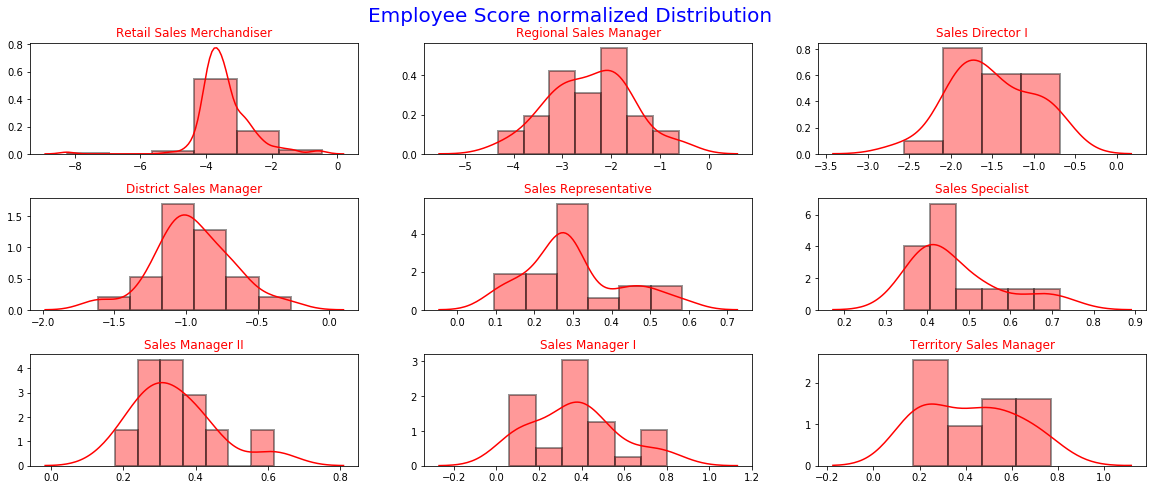

In [275]:
get_distribution_empscore(data_2,sales_like_job)

#### Employee score distribution without normalizing it, jobs like retail sales manager doesnt fall under normal distribution and if we check the distribution after transforming the distibution becomes normal

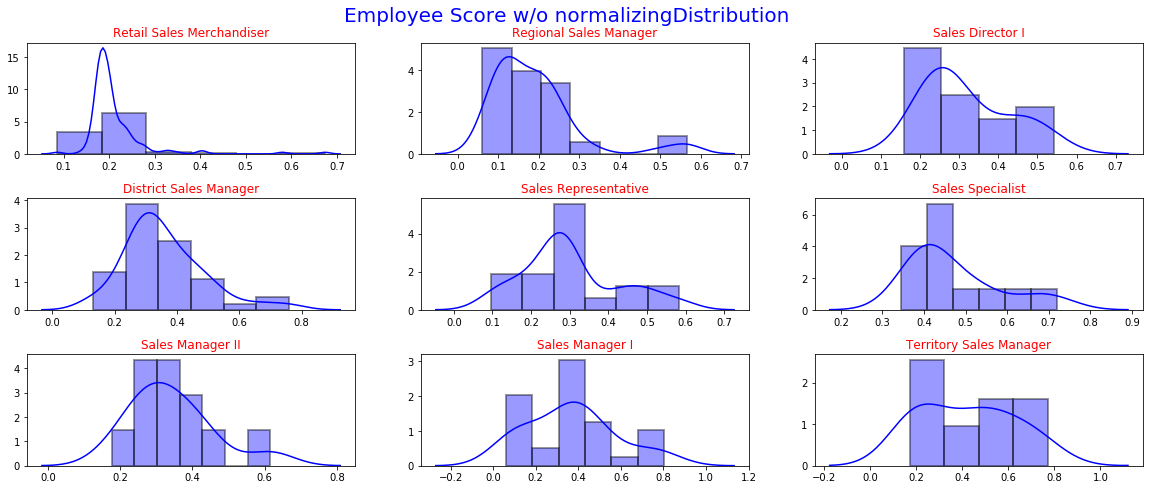

In [276]:
get_distribution_empscore_nonormalized(data_2,sales_like_job)

##### QQPlot will show all the points will be on the line if they are from normal distribution

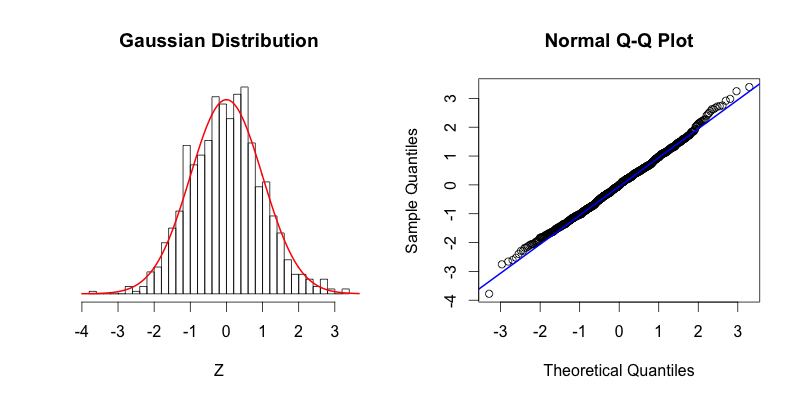

In [277]:
Image(filename="qqplot.png", width=700,height=400)

In [278]:
##Image(filename="withoutspan.JPG", width=700,height=400)

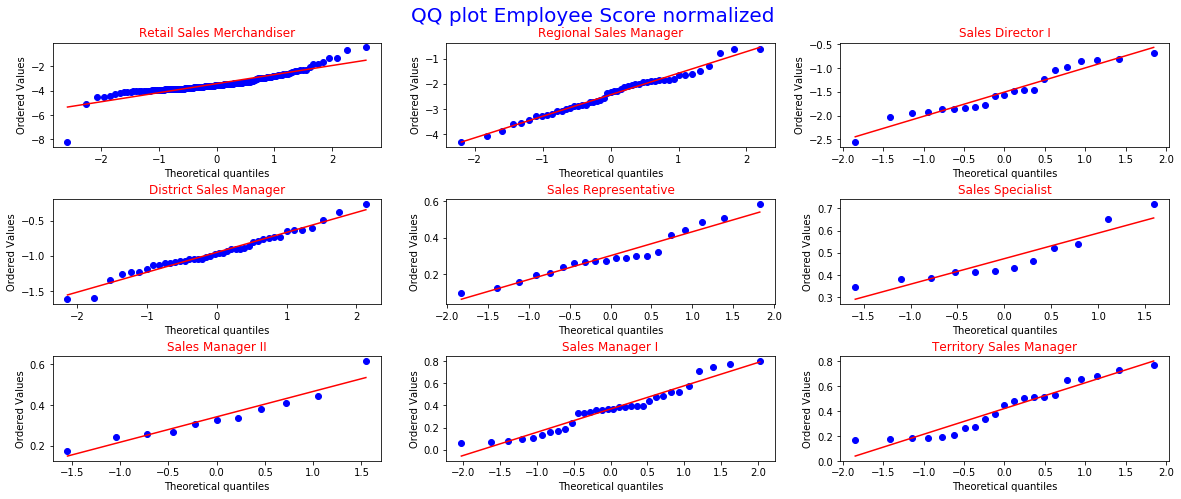

In [279]:
get_qqplot(data_2,sales_like_job)

## TODO : Plot in descending order of weightage
weightages of all the feature in sales like job.. we see that bonus_ratio('bonus') is highly weighted feature in most of the sales like job

In [280]:
def get_weights_distribution(dataframe,list_jobs=[]):
    size = 0
    if(list_jobs==[]):
        size = len(dataframe.job_dsc.unique())
    else:
        size = len(list_jobs)
    feature_name = ['Bonus','Salary','Compa_RT','Promotions','span']
    plt.figure(figsize=(20,25))
    gs2 = gridspec.GridSpec(len(list_jobs),3)
    for index ,job in enumerate(list_jobs):
        values = [dataframe[dataframe['job_dsc']==job].bonus_ratio_weightage.values[0],dataframe[dataframe['job_dsc']==job].salary_hike_weightage.values[0],dataframe[dataframe['job_dsc']==job].compa_rt_weightage.values[0],dataframe[dataframe['job_dsc']==job].promotion_rate_weightage.values[0],dataframe[dataframe['job_dsc']==job].span_change_weightage.values[0]]
        weights_dic = dict(zip(feature_name,values))
        weights_dic = sorted(weights_dic.items(), key=operator.itemgetter(1),reverse=True)
        sorted_dict = collections.OrderedDict(weights_dic)
        ##feature_weights = [data_2[data_2['job_dsc']==job].bonus_ratio_weightage.values[0],data_2[data_2['job_dsc']==job].salary_hike_weightage.values[0],data_2[data_2['job_dsc']==job].compa_rt_weightage.values[0],data_2[data_2['job_dsc']==job].promotion_rate_weightage.values[0]]
        ax=plt.subplot(gs2[index])
        sns.barplot(x=sorted_dict.keys(),y=sorted_dict.values())
        ##ax.bar(feature_name,[data_2[data_2['job_dsc']==job].bonus_ratio_weightage.values[0],data_2[data_2['job_dsc']==job].salary_hike_weightage.values[0],data_2[data_2['job_dsc']==job].compa_rt_weightage.values[0],data_2[data_2['job_dsc']==job].promotion_rate_weightage.values[0]])
        plt.subplots_adjust(hspace =0.4)
        ax.set_title(job,color='red')
    

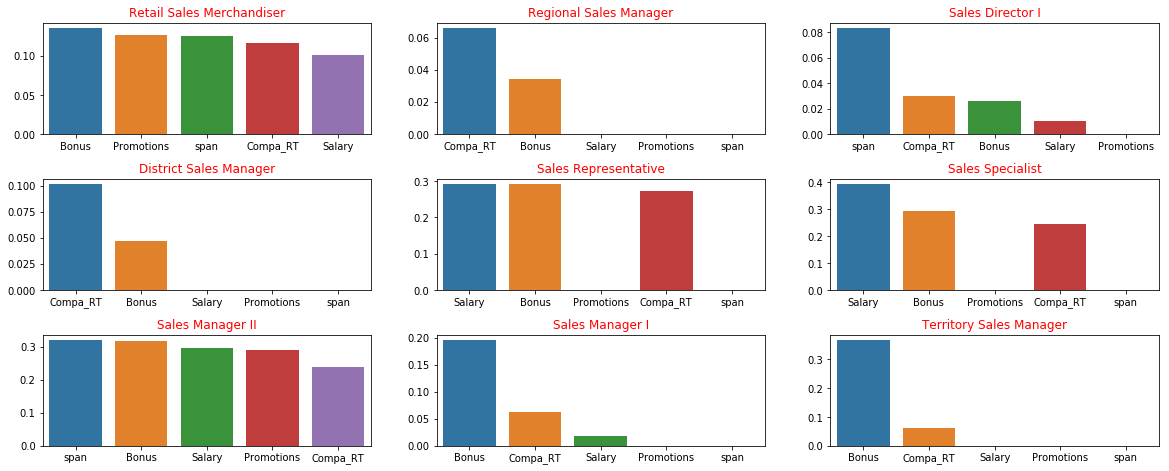

In [281]:
get_weights_distribution(data_2,sales_like_job)

#### checking are there any employee who are tagged as high performer w/o normalizing but they are not highperfomrer after transforming the score to normal

In [282]:
data_2[(data_2['Isbestperformer_normalized']!=data_2['Isbestperformer_nonorm']) & (data_2['Isbestperformer_normalized'].notnull()) & (data_2['Isbestperformer_nonorm'].notnull())]

,ooid,aoid,year,bonus_ratio,bonus_rate_change,salary_hike,compa_rt,salary_hike_rate_change,compa_rt_rate_change,span_change,...,bonus_rate_change_weightage,salary_hike_rate_change_weightage,compa_rt_rate_change_weightage,promotion_rate_change_weightage,employee_score,employee_score_normalized,employee_score_normalized_90_percentile,employee_score_90_percentile,Isbestperformer_normalized,Isbestperformer_nonorm


In [284]:
data_2.columns

Index([u'ooid', u'aoid', u'year', u'bonus_ratio', u'bonus_rate_change',
       u'salary_hike', u'compa_rt', u'salary_hike_rate_change',
       u'compa_rt_rate_change', u'span_change', u'job_dsc', u'tenure',
       u'promotions', u'promotion_rate_change', u'promotion_rate',
       u'bonus_ratio_normalised', u'salary_hike_normalised',
       u'compa_rt_normalised', u'promotion_rate_normalised',
       u'span_change_normalised', u'bonus_rate_change_normalised',
       u'salary_hike_rate_change_normalised',
       u'compa_rt_rate_change_normalised', u'promotion_rate_change_normalised',
       u'bonus_ratio_weightage', u'salary_hike_weightage',
       u'compa_rt_weightage', u'promotion_rate_weightage',
       u'span_change_weightage', u'bonus_rate_change_weightage',
       u'salary_hike_rate_change_weightage', u'compa_rt_rate_change_weightage',
       u'promotion_rate_change_weightage', u'employee_score',
       u'employee_score_normalized',
       u'employee_score_normalized_90_percentile'

In [285]:
data_2[(data_2['job_dsc']=='Territory Sales Manager') & (data_2['Isbestperformer_normalized'].notnull())]

,ooid,aoid,year,bonus_ratio,bonus_rate_change,salary_hike,compa_rt,salary_hike_rate_change,compa_rt_rate_change,span_change,...,bonus_rate_change_weightage,salary_hike_rate_change_weightage,compa_rt_rate_change_weightage,promotion_rate_change_weightage,employee_score,employee_score_normalized,employee_score_normalized_90_percentile,employee_score_90_percentile,Isbestperformer_normalized,Isbestperformer_nonorm
4847,G3AMKMQ4X429D89D,G3JV4VV5KJFCAJPD,2017,1.916088,-5.668232,3.0,0.833782,-29.988331,-6.311328,1.0001,...,0.02904,0.076675,0.051038,NaN,0.730162,0.730162,0.682698,0.682698,G3JV4VV5KJFCAJPD,G3JV4VV5KJFCAJPD
4848,G3AMKMQ4X429D89D,G3JV4VV5KJFCWH01,2017,2.001243,1.408936,3.0,0.926597,-33.993399,-0.654483,1.0001,...,0.02904,0.076675,0.051038,NaN,0.770385,0.770385,0.682698,0.682698,G3JV4VV5KJFCWH01,G3JV4VV5KJFCWH01


job_name>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>:Retail Sales Merchandiser
('values', [62.23776223776224, 94.4055944055944, 16.783216783216783, 62.23776223776224])
('values', [99.3006993006993, 16.083916083916083, 13.286713286713287, 99.3006993006993])
('values', [94.4055944055944, 100.0, 97.2027972027972, 94.4055944055944])
job_name>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>:District Sales Manager
('values', [54.76190476190476, 44.04761904761905, 95.23809523809524, 54.76190476190476])
('values', [52.38095238095238, 44.04761904761905, 97.61904761904762, 52.38095238095238])
('values', [100.0, 97.61904761904762, 83.33333333333333, 100.0])
job_name>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>:Sales Manager I
('values', [100.0, 34.375, 100.0, 100.0])
('values', [93.75, 59.375, 90.625, 93.75])
('values', [90.625, 82.8125, 96.875, 90.625])


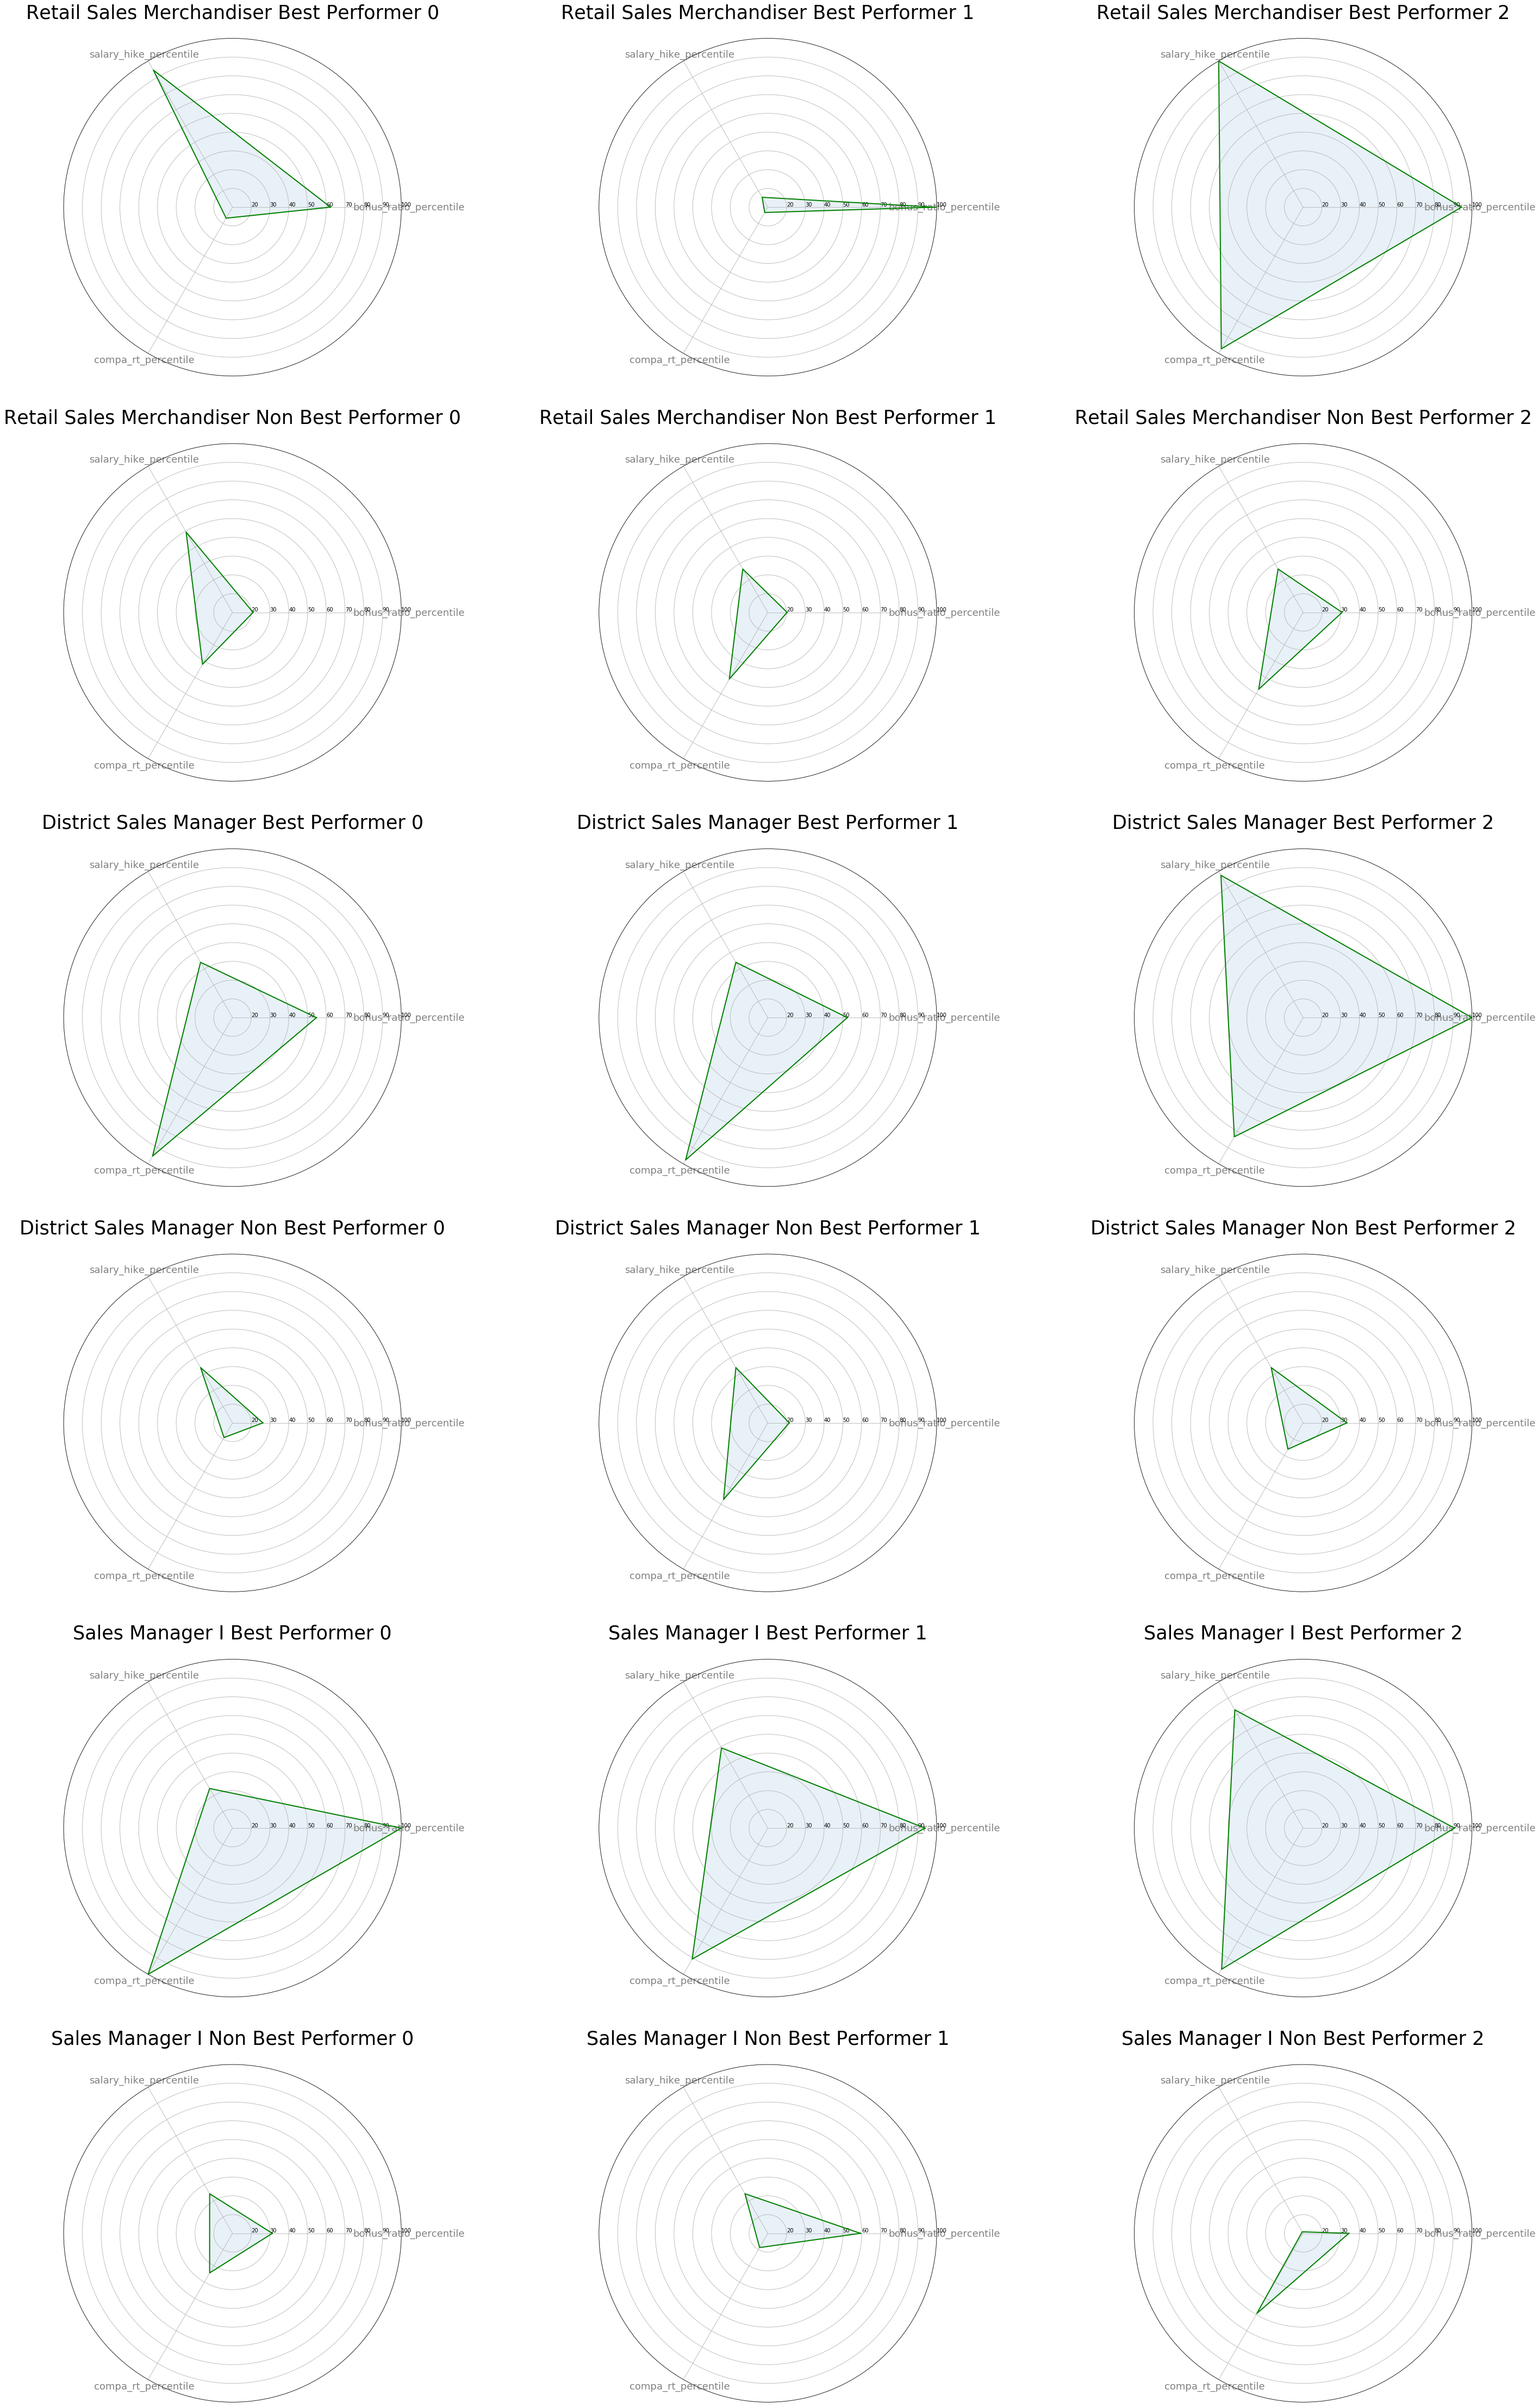

In [286]:
draw_percentile_radar_plot(3,data_2,["bonus_ratio_percentile","salary_hike_percentile","compa_rt_percentile"])

## For all jobs in wonderfull company

In [287]:
data.describe()

,year,bonus_ratio,bonus_rate_change,salary_hike,compa_rt,salary_hike_rate_change,compa_rt_rate_change,span_change,tenure,promotions,promotion_rate_change,promotion_rate
count,5251.0,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000
mean,2017.0,0.257829,63.057895,7.654226,1.841098,62.237894,8.579144,1.024908,6.368899,0.378214,0.407486,0.124352
std,0.0,0.470083,630.057974,9.887519,1.653228,270.650550,77.284688,10.439518,5.988293,0.639474,3.840532,0.280679
min,2017.0,0.000000,-429.575160,0.000000,0.017908,-100.000000,-98.034931,0.000100,1.000000,0.000000,0.000000,0.000000
25%,2017.0,0.120194,-17.191935,3.000000,1.012482,-16.666667,-9.854492,0.000100,2.185000,0.000000,0.000000,0.000000
50%,2017.0,0.175489,0.000000,5.172500,1.337318,0.000000,-0.332933,0.000100,4.370000,0.000000,0.000000,0.000000
75%,2017.0,0.265128,17.495831,9.069583,1.907194,57.500000,12.755832,0.978571,8.590000,1.000000,0.000000,0.163936
max,2017.0,7.875943,32534.095455,225.480000,22.343273,6861.386139,4059.125544,540.000100,44.920000,5.000000,100.000000,3.937008


In [288]:
data.columns

Index([u'ooid', u'aoid', u'year', u'bonus_ratio', u'bonus_rate_change',
       u'salary_hike', u'compa_rt', u'salary_hike_rate_change',
       u'compa_rt_rate_change', u'span_change', u'job_dsc', u'tenure',
       u'promotions', u'promotion_rate_change', u'promotion_rate'],
      dtype='object')

In [289]:
data[data.bonus_rate_change==max1]
# data["bonus_rate_change"]

,ooid,aoid,year,bonus_ratio,bonus_rate_change,salary_hike,compa_rt,salary_hike_rate_change,compa_rt_rate_change,span_change,job_dsc,tenure,promotions,promotion_rate_change,promotion_rate
4820,G3AMKMQ4X429D89D,G37FPGW57N718CJF,2017,3.405664,32534.095455,9.16,3.578704,104.008909,341.156096,0.0001,Irrigation Maintenance,29.13,0.0,0.0,0.0


In [290]:
col_names = ['bonus_ratio','salary_hike','compa_rt','promotion_rate','span_change',
             'bonus_rate_change','salary_hike_rate_change','compa_rt_rate_change','promotion_rate_change']
col_names_normalised=[col+"_normalised" for col in col_names]
normalize=lambda x: (x - x.min()) / (x.max() - x.min())
data[col_names_normalised] = data.groupby(["ooid","job_dsc"])[col_names].transform(normalize)
data=data.groupby(["job_dsc"]).apply(calculate_employee_score_with_normalised)
data=data.groupby("job_dsc").apply(detect_bestperformer)

************************************************************
--using MAD important feature:-
Admin I
('sorted_std', [('promotion_rate', 0.0), ('salary_hike', 0.10425), ('salary_hike_rate_change', 0.12943560436276708), ('bonus_rate_change', 0.17597620362937905), ('compa_rt_rate_change', 0.20056747027137267), ('bonus_ratio', 0.23031094418903819), ('compa_rt', 0.27515808543321785)])
Statistics=0.917, p=0.294
('After transforming p value:', 0.29428690671920776)
************************************************************
--using MAD important feature:-
Admin I
('sorted_std', [('promotion_rate', 0.0), ('salary_hike', 0.10425), ('salary_hike_rate_change', 0.12943560436276708), ('bonus_rate_change', 0.17597620362937905), ('compa_rt_rate_change', 0.20056747027137267), ('bonus_ratio', 0.23031094418903819), ('compa_rt', 0.27515808543321785)])
Statistics=0.917, p=0.294
('After transforming p value:', 0.29428690671920776)
************************************************************
--using MAD imp

('sorted_std', [('promotion_rate', 0.0), ('salary_hike', 0.06535947712418301), ('compa_rt_rate_change', 0.074850019825177805), ('bonus_ratio', 0.088225557574453467), ('salary_hike_rate_change', 0.10686990720304868), ('bonus_rate_change', 0.10969109960891903), ('compa_rt', 0.17838013892041843)])
Statistics=0.881, p=0.132
('After transforming p value:', 0.13239118456840515)
************************************************************
--using MAD important feature:-
Cellar Worker
('sorted_std', [('promotion_rate_change', 0.0), ('promotion_rate', 0.0), ('bonus_rate_change', 0.0069272227781486586), ('salary_hike_rate_change', 0.035585471823391404), ('compa_rt_rate_change', 0.082412169713717398), ('bonus_ratio', 0.12029608124231916), ('salary_hike', 0.12654887563102343), ('compa_rt', 0.131326095246564)])
Statistics=0.965, p=0.487
('After transforming p value:', 0.4874739348888397)
************************************************************
--using Standard Deviation important feature:-
Chem

Statistics=0.960, p=0.535
('After transforming p value:', 0.5352501273155212)
************************************************************
--using MAD important feature:-
Engineer
('sorted_std', [('promotion_rate', 0.0), ('span_change', 0.0), ('compa_rt_rate_change', 0.020479123243041131), ('compa_rt', 0.029147377850357065), ('salary_hike_rate_change', 0.05335973796557146), ('salary_hike', 0.056875000000000002), ('bonus_rate_change', 0.12556096812065637), ('bonus_ratio', 0.26826998508168853)])
Statistics=0.969, p=0.545
('After transforming p value:', 0.5449581742286682)
************************************************************
--using MAD important feature:-
Equipment Operator III
('sorted_std', [('promotion_rate', 0.0), ('bonus_rate_change', 0.0023743573783684795), ('bonus_ratio', 0.007592658376575601), ('salary_hike_rate_change', 0.024506828230360857), ('compa_rt_rate_change', 0.042398194499778261), ('compa_rt', 0.063511945718982388), ('salary_hike', 0.10393756651294783)])
Statist

Statistics=0.964, p=0.344
('After transforming p value:', 0.3437683880329132)
************************************************************
--using Standard Deviation important feature:-
Mechanic I
('sorted_std', [('bonus_ratio', 0.2065898284643776), ('compa_rt_rate_change', 0.22214785312758298), ('bonus_rate_change', 0.229557877160882), ('salary_hike', 0.2486476165006276), ('salary_hike_rate_change', 0.2782343103994048), ('compa_rt', 0.2806789676971577), ('promotion_rate', 0.2547814280291903)])
Statistics=0.876, p=0.015
('After transforming p value:', 0.03326459974050522)
************************************************************
--using Standard Deviation important feature:-
Mechanic II
('sorted_std', [('compa_rt', 0.17052807458664138), ('compa_rt_rate_change', 0.18101187032261556), ('bonus_rate_change', 0.18761518718891473), ('bonus_ratio', 0.1878296342325837), ('salary_hike', 0.26474880355566804), ('promotion_rate', 0.22079346508664421), ('salary_hike_rate_change', 0.2740670214001

('After transforming p value:', 0.46595242619514465)
************************************************************
--using MAD important feature:-
Supervisor
('sorted_std', [('promotion_rate', 0.0), ('span_change', 0.02222222222222222), ('compa_rt_rate_change', 0.022371106417767517), ('salary_hike', 0.039757271395689485), ('salary_hike_rate_change', 0.051915265104976266), ('bonus_rate_change', 0.080038145056026355), ('bonus_ratio', 0.11042742962929514), ('compa_rt', 0.20702362278897962)])
Statistics=0.944, p=0.218
('After transforming p value:', 0.21772661805152893)
************************************************************
--using MAD important feature:-
Supervisor - Crop
('sorted_std', [('promotion_rate_change', 0.0), ('promotion_rate', 0.0), ('bonus_ratio', 0.0030786613680745846), ('bonus_rate_change', 0.0032959059165527083), ('compa_rt_rate_change', 0.0037845379486969102), ('salary_hike', 0.0086885115626076162), ('compa_rt', 0.0091596272965818685), ('salary_hike_rate_change', 0.01

In [291]:
df_highperformer_all = pd.merge(data.groupby('job_dsc').aoid.nunique().to_frame(name='total_employee').reset_index(),data[data['Isbestperformer_normalized'].notnull()].groupby('job_dsc').Isbestperformer_normalized.nunique().to_frame(name='HighPerformer').reset_index(),on='job_dsc')   
df_highperformer_all['HighPerformer%'] = (df_highperformer_all['HighPerformer']/df_highperformer_all['total_employee'])*100
df_highperformer_all.sort_values(by="HighPerformer%",ascending=False)

,job_dsc,total_employee,HighPerformer,HighPerformer%
102,Sales Specialist,12,2,16.666667
37,Counsel,12,2,16.666667
88,Professional Coordinator (EX),12,2,16.666667
26,Associate VIII,13,2,15.384615
52,Executive Assistant,13,2,15.384615
84,Professional Administrator,13,2,15.384615
32,Chemical Operator,14,2,14.285714
2,Admin III,14,2,14.285714
58,General Labor,14,2,14.285714
117,Technician - Irrigation,14,2,14.285714


In [292]:
data[data['Isbestperformer_normalized'].notnull()].sort_values(by="job_dsc",ascending=False).to_csv("final.csv")

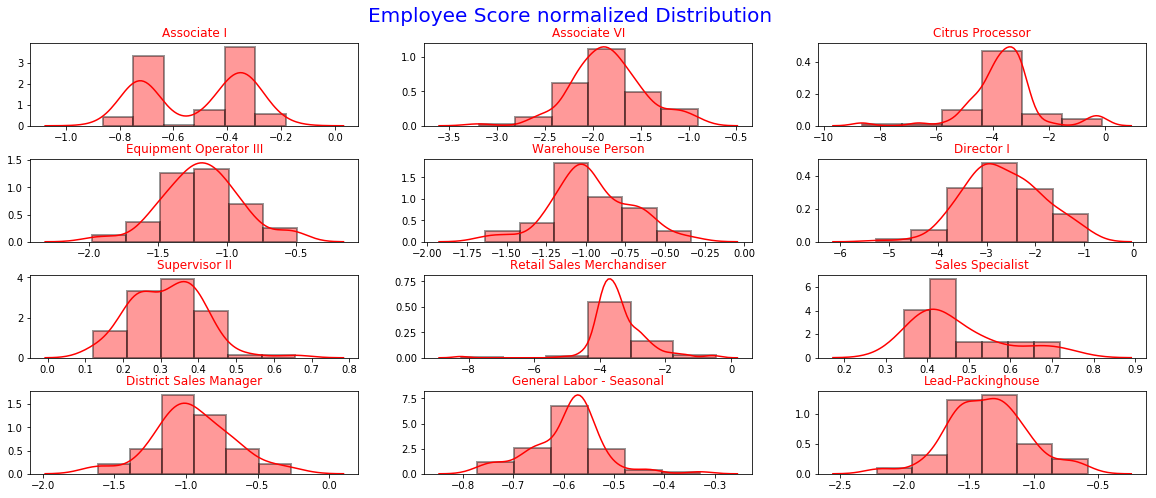

In [293]:
get_distribution_empscore(data,lis_jobs)

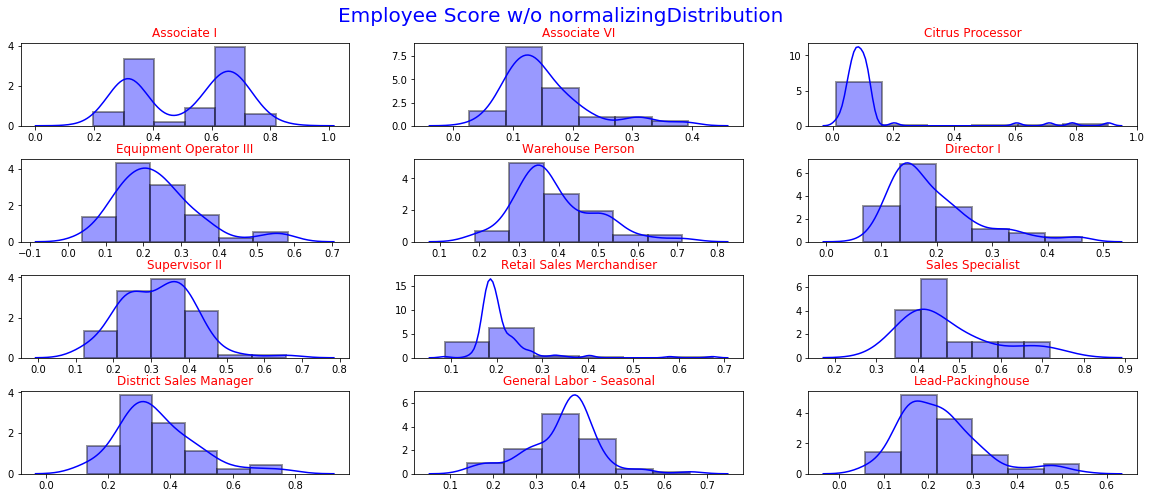

In [294]:
get_distribution_empscore_nonormalized(data,lis_jobs)

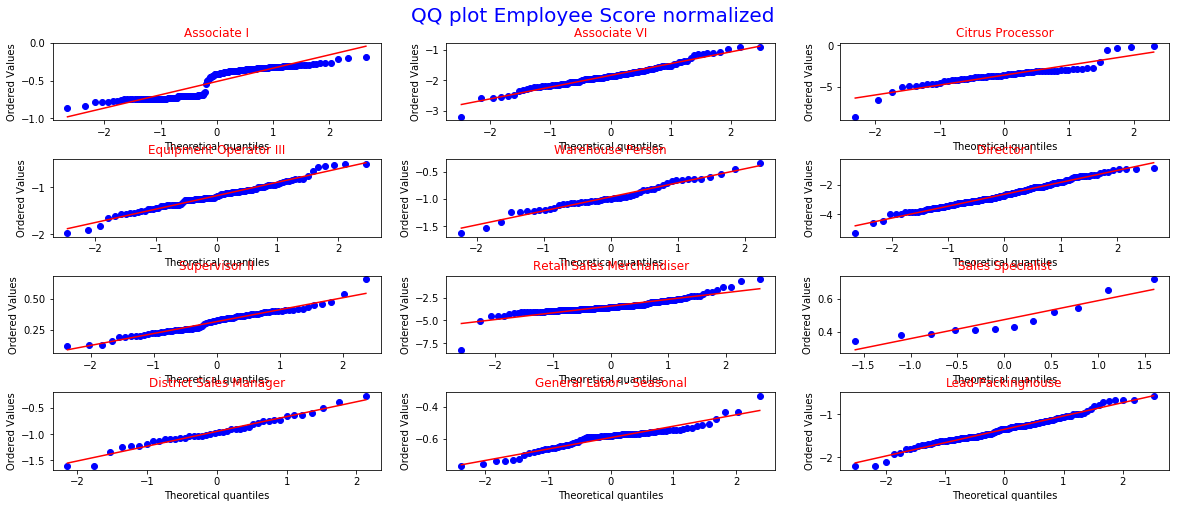

In [295]:
get_qqplot(data,lis_jobs)

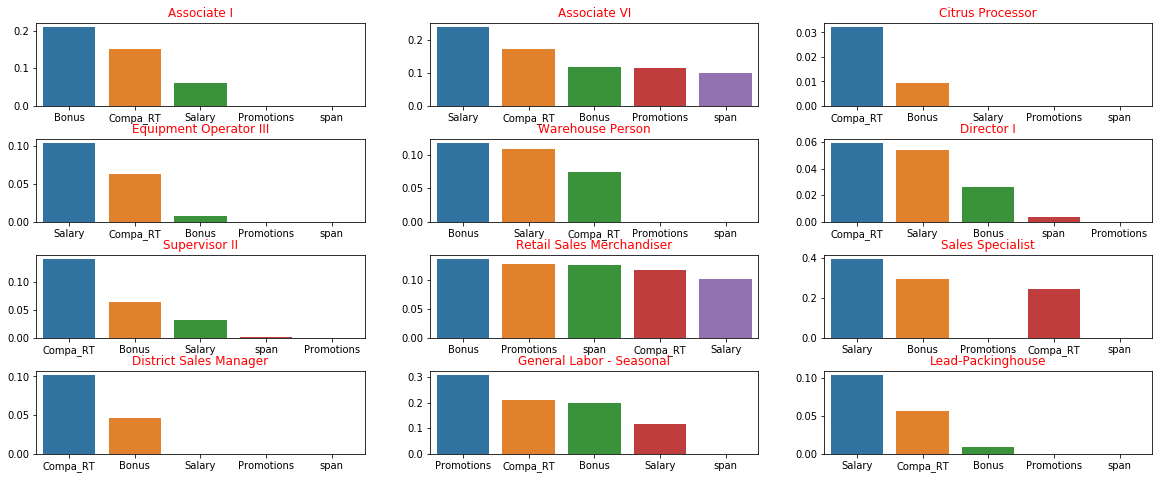

In [296]:
get_weights_distribution(data,lis_jobs)

In [297]:
data[data['Isbestperformer_normalized'].notnull()]['aoid']

42      G37FPGW57N71A94B
54      G37SPKAVNY7N1VE1
55      G38Q3F1KVPSMEGD7
58      G39GD4JD4FH7DZC0
62      G3AGFPHR8D7G6JTY
65      G3D0G751HMBQCADV
66      G3DDK8BE5ENY1K85
67      G3DFH3N5V35Z2B6F
68      G3DFH3N5V35ZHQ1X
73      G3E8WM0T9VDZVTWX
116     G3KWB7THYPZTMN11
119     G3KWB7THYPZTR7Y1
132     G3PSTTJ7F5GZAXSF
139     G3W34W4XFQP6EDA9
146     G3ZKDT492B1ESRFQ
178     G37N1CBMZ78VQ2FN
179     G37N1CBMZ78VQZMH
194     G38TPKXJZHDD1D1M
201     G38TPKXJZHDD9AJ4
203     G38TPKXJZHDDD99B
209     G38TPKXJZHDDJ8CJ
212     G38TPKXJZHDDP00N
216     G38TPKXJZHDDTX0K
218     G38TPKXJZHDDW7S5
222     G38TPKXJZHDDYDQF
223     G38TPKXJZHDDZCNC
229     G39D8PHG4JRJ5X7M
230     G39D8PHG4JRJ90DY
244     G39D8PHG4JRJN2KX
250     G39D8PHG4JRJTYSH
              ...       
5690    G38TPKXJZHDDZTJR
5712    G3KWB7THYPZT44PW
5713    G3KWB7THYPZTGNA7
5718    G3WEB3CDS47R3FVT
5725    G3WEB3CDS47RAFAF
5737    G3XVGAP0K0K4FEZC
5802    G3KWB7THYPZTW2WW
5805    G37N1CBMZ78V0M3E
5810    G38TPKXJZHDDZTJR


##### for a WFN client 

In [353]:
data_wfn = pd.read_csv("wfn_G3DT7PGGYDWKSXT0.csv",header=0)
print('shape before removing:-',data_wfn.shape, data.aoid.nunique())
cleandf(data_wfn)
# print('removing:-',data_wfn.shape)
data_wfn = data_wfn.groupby('job_dsc').apply(set_span)
print('shape after removing:-',data_wfn.shape)

('shape before removing:-', (10868, 10), 4702)
('shape after removing:-', (10805, 11))


In [354]:
data_wfn.shape

(10805, 11)

In [355]:
data_wfn = getDataframe_30Emp(data_wfn,year=2017,cutoff=10)

In [356]:
data_wfn.head()

,ooid,aoid,year,bonus_ratio,salary_hike,compa_rt,span_change,job_dsc,tenure,promotions,promotion_rate
0,G3DT7PGGYDWKSXT0,G36AD26NXHBF0900,2017,0.0,0.000,1.063156,0.0001,Cashier,0.21,0.0,0.0
1,G3DT7PGGYDWKSXT0,G3DTT2E37Z0TEH1S,2017,0.0,0.500,1.371118,0.0001,Cashier,1.27,0.0,0.0
2,G3DT7PGGYDWKSXT0,G3QYH82FDSV4M0V0,2017,0.0,0.000,1.674801,0.0001,Cashier,0.17,0.0,0.0
3,G3DT7PGGYDWKSXT0,G3VK4J1RQY4R827Z,2017,0.0,11.805,1.029815,0.0001,Cashier,2.08,0.0,0.0
4,G3DT7PGGYDWKSXT0,G3RE6BP7VMG5K7KW,2017,0.0,0.000,0.397824,0.0001,Cashier,0.42,0.0,0.0


In [357]:
col_names = ['bonus_ratio','salary_hike','compa_rt','promotion_rate','span_change']
col_names_normalised=[col+"_normalised" for col in col_names]
normalize=lambda x: (x - x.min()) / (x.max() - x.min())
data_wfn[col_names_normalised] = data_wfn.groupby(["ooid","job_dsc"])[col_names].transform(normalize)

In [358]:
data_wfn = data_wfn.groupby('job_dsc').apply(calculate_employee_score_with_normalised)

--using Standard Deviation important feature:-
3rd Key Manager
('sorted_std', [('salary_hike', 0.15954096921683608), ('span_change', 0.16831954251112444), ('compa_rt', 0.21822214386853117)])
************************************************************
--using Standard Deviation important feature:-
3rd Key Manager
('sorted_std', [('salary_hike', 0.15954096921683608), ('span_change', 0.16831954251112444), ('compa_rt', 0.21822214386853117)])
************************************************************
--using Standard Deviation important feature:-
4th Key Manager
('sorted_std', [('salary_hike', 0.16601124536613798), ('span_change', 0.17211539844064738), ('compa_rt', 0.19418518069792715)])
************************************************************
--using Standard Deviation important feature:-
Assistant Food Service Manager
('sorted_std', [('compa_rt', 0.14688689255834544), ('span_change', 0.15409140951745615), ('salary_hike', 0.25094301070444475)])
**************************************

In [359]:
data_wfn=data_wfn.groupby("job_dsc").apply(detect_bestperformer)

In [360]:
data_wfn_highperformer_all = pd.merge(data_wfn.groupby('job_dsc').aoid.nunique().to_frame(name='total_employee').reset_index(),data_wfn[data_wfn['Isbestperformer_normalized'].notnull()].groupby('job_dsc').Isbestperformer_normalized.nunique().to_frame(name='HighPerformer').reset_index(),on='job_dsc')   
data_wfn_highperformer_all['HighPerformer%'] = (data_wfn_highperformer_all['HighPerformer']/data_wfn_highperformer_all['total_employee'])*100
data_wfn_highperformer_all

,job_dsc,total_employee,HighPerformer,HighPerformer%
0,3rd Key Manager,75,8,10.666667
1,4th Key Manager,88,9,10.227273
2,Assistant Food Service Manager,143,15,10.489510
3,Assistant Grocery Manager,93,10,10.752688
4,Assistant Meat Manager,87,9,10.344828
5,Assistant Produce Manager,97,10,10.309278
6,Assistant Store Director,90,9,10.000000
7,Assistant Vitamin/Body Care Manager,110,11,10.000000
8,Bakery Clerk,329,33,10.030395
9,Bakery Supervisor,121,12,9.917355


#### validating for job whoever is highperformer should have his attribute value more than the median in that job